In [11]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

Available workers: 8


In [23]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

setting = 'fuji'

Available workers: 8
Available workers: 8


In [30]:
dfs = InsectImgDataset(setting=setting)
dfs.extract_df_info()

Extracting info from filenames..: 100%|█| 67841/67841 [00:07<00:00, 8528.92it/s]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 55.24it/s]


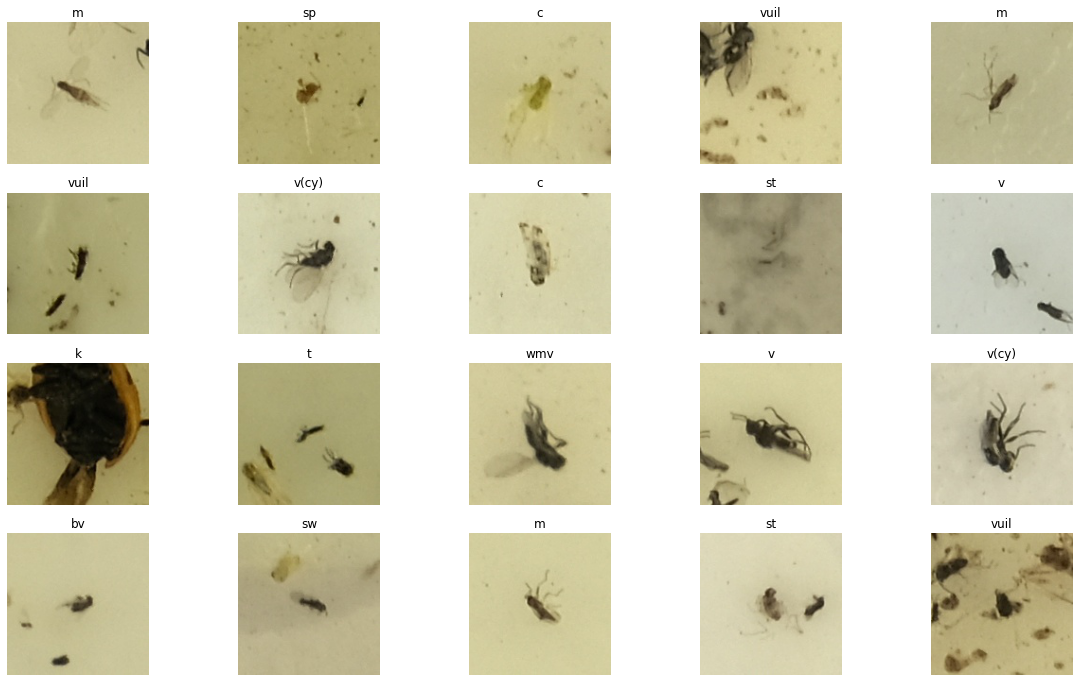

In [31]:
dfs.plot_samples()

In [32]:
batch_size=32
dloader = DataLoader(dfs, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [34]:
blur_factors = []
for x,l,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(dloader, total=len(dfs)//batch_size, desc='Collecting all data from the dataloader..'):
    for f in filename:
        blur_factors.extend([variance_of_laplacian(f)])
    break

Available workers: 8
Available workers: 8


In [41]:
a,b,c = x[0].size()

In [42]:
a


3

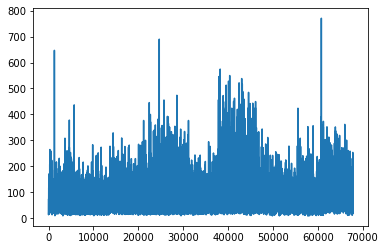

In [8]:
plt.plot(blur_factors)

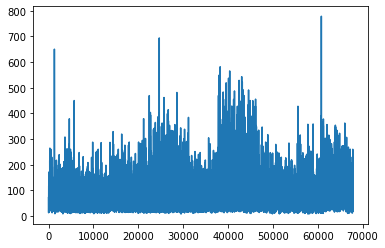

In [46]:
plt.plot(blur_factors)

In [9]:
dfs.df['blur'] = blur_factors

  0%|                                                    | 0/20 [00:00<?, ?it/s]


AttributeError: 'float' object has no attribute 'read'

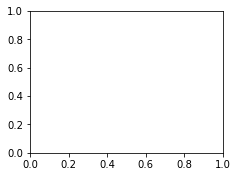

In [10]:
dfs.plot_samples(dfs.df[dfs.df.blur>450])

201.87350217283947


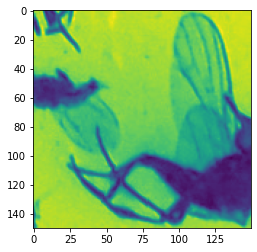

In [30]:
import cv2

n=23430
# img = np.array(Image.open(dfs[n][4]))#cv2.imread(dfs[n][4], 0)
print(variance_of_laplacian(dfs[n][4]))
plt.imshow(dfs[n][0][0][0])

14.803101432098767